# Loading Data/Libraries

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("SPX_database_2010.xlsx")
df_total_ret = pd.read_excel("SPX_database_2010.xlsx", sheet_name="total_ret")
df_price = pd.read_excel("SPX_database_2010.xlsx", sheet_name="prices")


In [4]:
import matplotlib.pyplot as plt

# Part A

# Choosing 30 random companies that existed from 2015-2024

In [29]:
# Convert Dates column to datetime
df_total_ret["Dates"] = pd.to_datetime(df_total_ret["Dates"])
df_price["Dates"] = pd.to_datetime(df_price["Dates"])

# Filter data for 2015-2024
mask = (df_total_ret["Dates"] >= "2015-01-01") & (df_total_ret["Dates"] <= "2024-12-31")
df_filtered = df_total_ret.loc[mask]

# Drop the Dates column to focus only on companies
df_companies = df_filtered.drop(columns=["Dates"])

# Keep only companies with NO NaN in that period
valid_companies = df_companies.columns[df_companies.notna().all()]

# Randomly choose 30 companies
np.random.seed(41)  
selected_companies = np.random.choice(valid_companies, size=30, replace=False)

print("Selected companies:")
print(selected_companies)


Selected companies:
['WAB UN Equity' 'TFC UN Equity.1' 'LKQ UW Equity.1' 'RSG UN Equity'
 'CMS UN Equity.1' 'APTV UN Equity.1' 'IDXX UW Equity.1' 'RMD UN Equity'
 'PNR UN Equity.1' 'FAST UW Equity.1' 'TTWO UW Equity' 'NWSA UW Equity'
 'GOOG UW Equity' 'NRG UN Equity' 'SYK UN Equity.1' 'CTRA UN Equity'
 'WM UN Equity' 'TMO UN Equity.1' 'CAG UN Equity.1' 'NOW UN Equity.1'
 'NDAQ UW Equity' 'KEY UN Equity.1' 'HUBB UN Equity.1' 'CRM UN Equity.1'
 'ROK UN Equity.1' 'MNST UW Equity' 'AEE UN Equity.1' 'LVS UN Equity'
 'AMGN UW Equity.1' 'ZTS UN Equity']


# Collect daily returns for selected companies and EW & VW portfolios


In [30]:
# --- Step 1: Filter only the 30 selected companies (from earlier step) ---
df_prices_selected = df_price[["Dates"] + list(selected_companies)]

# --- Step 2: Keep only 2015–2024 ---
mask = (df_prices_selected["Dates"] >= "2015-01-01") & (df_prices_selected["Dates"] <= "2024-12-31")
df_prices_filtered = df_prices_selected.loc[mask].set_index("Dates")

# --- Step 3: Compute daily log returns ---
df_returns = np.log(df_prices_filtered / df_prices_filtered.shift(1)).dropna()

# --- Step 4: Equally weighted portfolio return ---
df_returns["Equal_Weighted_Portfolio"] = df_returns.mean(axis=1)

# --- Final check ---
print(df_returns.head())

            WAB UN Equity  TFC UN Equity.1  LKQ UW Equity.1  RSG UN Equity  \
Dates                                                                        
2015-01-02       0.002529        -0.006190        -0.012165       0.007919   
2015-01-05      -0.022875        -0.032074        -0.012497      -0.005685   
2015-01-06      -0.013004        -0.019696        -0.017836       0.003464   
2015-01-07       0.009710         0.013263         0.014002      -0.003464   
2015-01-08       0.020297         0.016534         0.010555       0.009130   

            CMS UN Equity.1  APTV UN Equity.1  IDXX UW Equity.1  \
Dates                                                             
2015-01-02         0.011161         -0.001790         -0.006360   
2015-01-05        -0.008287         -0.044651         -0.006947   
2015-01-06         0.001720         -0.006359          0.003207   
2015-01-07         0.016196          0.007942          0.019966   
2015-01-08         0.005341          0.024297      

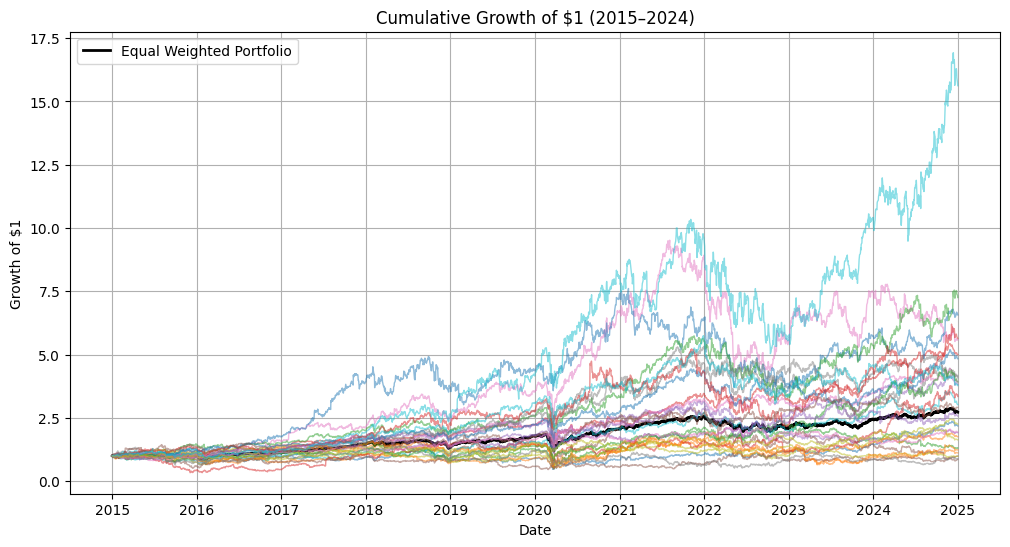

In [31]:
df_cum_returns = np.exp(df_returns.cumsum())

# --- Step 6: Plot cumulative growth of $1 ---
plt.figure(figsize=(12,6))
plt.plot(df_cum_returns.index, df_cum_returns["Equal_Weighted_Portfolio"], label="Equal Weighted Portfolio", linewidth=2, color="black")

# Optional: plot individual companies (light lines)
for col in selected_companies:
    plt.plot(df_cum_returns.index, df_cum_returns[col], alpha=0.5, linewidth=1)

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
df_mktcap = pd.read_excel("SPX_database_2010.xlsx", sheet_name="mkt_cap")

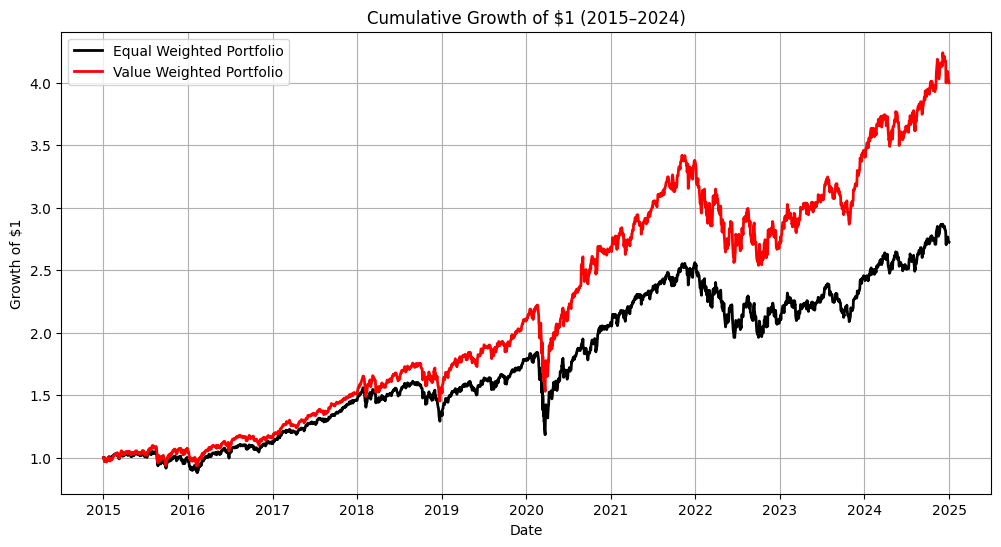

In [33]:
# Load market cap sheet
df_mktcap["Dates"] = pd.to_datetime(df_mktcap["Dates"])

# Keep only Dates + selected companies
df_mktcap_selected = df_mktcap[["Dates"] + list(selected_companies)]

# Filter to 2015–2024
mask = (df_mktcap_selected["Dates"] >= "2015-01-01") & (df_mktcap_selected["Dates"] <= "2024-12-31")
df_mktcap_filtered = df_mktcap_selected.loc[mask].set_index("Dates")

# Align with returns dataframe (important!)
df_mktcap_filtered = df_mktcap_filtered.loc[df_returns.index]

# --- Step 1: Compute weights (row-wise normalization) ---
weights = df_mktcap_filtered.div(df_mktcap_filtered.sum(axis=1), axis=0)

# --- Step 2: Value-weighted portfolio return ---
# Multiply each stock's return by its weight, then sum across columns
vw_returns = (df_returns[selected_companies] * weights).sum(axis=1)

# Add to dataframe
df_returns["Value_Weighted_Portfolio"] = vw_returns

# --- Step 3: Compute cumulative returns (growth of $1) ---
df_cum_returns = np.exp(df_returns.cumsum())

# --- Step 4: Plot ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_cum_returns.index, df_cum_returns["Equal_Weighted_Portfolio"], label="Equal Weighted Portfolio", linewidth=2, color="black")
plt.plot(df_cum_returns.index, df_cum_returns["Value_Weighted_Portfolio"], label="Value Weighted Portfolio", linewidth=2, color="red")

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


# Rebalance

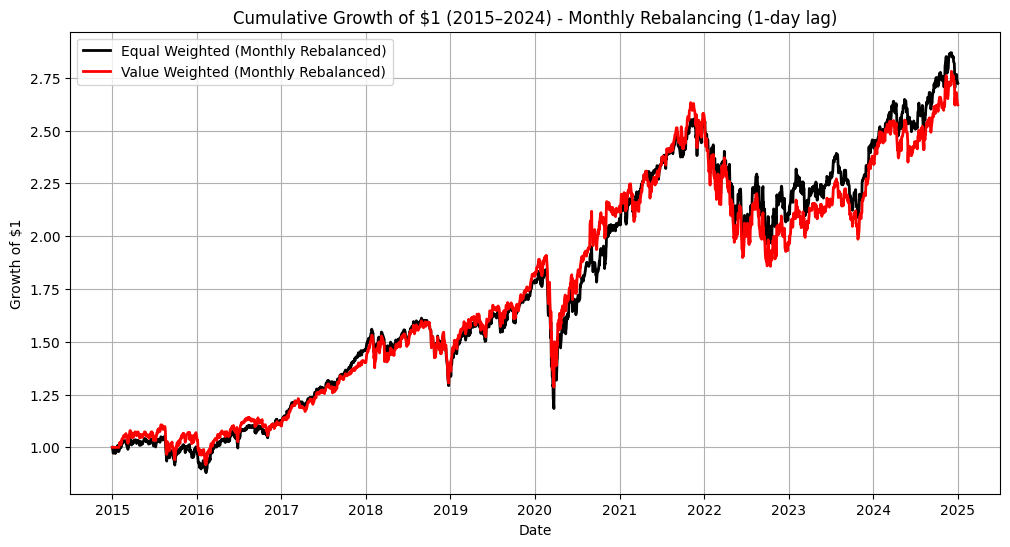

In [34]:
selected = list(selected_companies)  # just for shorter notation

# --- Step 1: Compute daily lagged market cap weights ---
weights_daily = df_mktcap_filtered.div(df_mktcap_filtered.sum(axis=1), axis=0)
weights_daily = weights_daily.shift(1)   # 1-day lag so we don't use future info

# --- Step 2: Identify first trading day of each month ---
first_days = df_returns.groupby([df_returns.index.year, df_returns.index.month]).apply(lambda x: x.index[0])

# --- Step 3: Extract weights for rebalancing dates ---
vw_monthly_weights = weights_daily.loc[first_days]

# Forward-fill weights to all days until next rebalance
vw_monthly_weights = vw_monthly_weights.reindex(df_returns.index, method="ffill")

# --- Step 4: Value-weighted portfolio returns ---
vw_portfolio = (df_returns[selected] * vw_monthly_weights).sum(axis=1)

# --- Step 5: Equal-weight portfolio ---
n = len(selected)
ew_monthly_weights = pd.DataFrame(1/n, index=first_days, columns=selected)
ew_monthly_weights = ew_monthly_weights.reindex(df_returns.index, method="ffill")

ew_portfolio = (df_returns[selected] * ew_monthly_weights).sum(axis=1)

# --- Step 6: Add to returns DataFrame ---
df_returns["VW_Rebalanced"] = vw_portfolio
df_returns["EW_Rebalanced"] = ew_portfolio

# --- Step 7: Compute cumulative growth of $1 ---
df_cum = np.exp(df_returns.cumsum())

# --- Step 8: Plot ---
plt.figure(figsize=(12,6))
plt.plot(df_cum.index, df_cum["EW_Rebalanced"], label="Equal Weighted (Monthly Rebalanced)", color="black", linewidth=2)
plt.plot(df_cum.index, df_cum["VW_Rebalanced"], label="Value Weighted (Monthly Rebalanced)", color="red", linewidth=2)

plt.title("Cumulative Growth of $1 (2015–2024) - Monthly Rebalancing (1-day lag)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()

# Portfolio turnover

In [61]:
# Monthly
first_days_1m = df_returns.resample("MS").first().index

# Semi-annual (every 6 months)
first_days_6m = df_returns.resample("6MS").first().index

In [64]:
# Daily cap weights (no lag yet)
caps = df_mktcap_filtered.loc[df_returns.index, selected]

# 1-day lag so we never use future info for trading at the open
caps_lag = caps.shift(1)

# Helper: weights at *exact* rebalance dates
def vw_targets_on(dates_index):
    # Use nearest available index for each rebalance date
    c = caps_lag.reindex(dates_index, method='nearest')
    w = c.div(c.sum(axis=1), axis=0)
    return w

vw_monthly_targets = vw_targets_on(first_days_1m)
vw_6m_targets = vw_targets_on(first_days_6m)

# For portfolio construction between rebalances:
vw_monthly_weights_path = vw_monthly_targets.reindex(df_returns.index, method="ffill")
vw_6m_weights_path = vw_6m_targets.reindex(df_returns.index, method="ffill")

# EW targets are trivial at the rebalance dates
n = len(selected)
ew_monthly_targets = pd.DataFrame(1/n, index=first_days_1m, columns=selected)
ew_6m_targets = pd.DataFrame(1/n, index=first_days_6m, columns=selected)


In [65]:
def compute_turnover_with_drift(returns, targets):
    """
    returns: daily simple returns (DataFrame, index daily)
    targets: target weights ONLY at rebalance dates (DataFrame)
             Each row must correspond to the first trading day of a new period,
             defined with t-1 (lagged) information.
    """
    turnovers = {}
    rebalance_dates = targets.index

    for i in range(1, len(rebalance_dates)):
        start = rebalance_dates[i-1]
        end   = rebalance_dates[i]

        # weights right after rebalancing at 'start'
        w0 = targets.loc[start].values

        # apply drift over (start, end] using simple returns
        rets = returns.loc[start:end]
        w = w0.copy()
        for _, r in rets.iloc[1:].iterrows():
            w = w * (1 + r.values)
            w = w / w.sum()

        # target for 'end' (built from t-1 info for 'end')
        w_star = targets.loc[end].values

        turnovers[end] = 0.5 * np.abs(w_star - w).sum()

    return pd.Series(turnovers)


In [66]:
# Simple returns from your log returns
df_simple_returns = np.exp(df_returns[selected]) - 1

# Monthly turnover
ew_turnover_1m = compute_turnover_with_drift(df_simple_returns, ew_monthly_targets)
vw_turnover_1m = compute_turnover_with_drift(df_simple_returns, vw_monthly_targets)

print("Average EW turnover (1M):", ew_turnover_1m.mean())
print("Average VW turnover (1M):", vw_turnover_1m.mean())

# Semi-annual turnover
ew_turnover_6m = compute_turnover_with_drift(df_simple_returns, ew_6m_targets)
vw_turnover_6m = compute_turnover_with_drift(df_simple_returns, vw_6m_targets)

print("Average EW turnover (6M):", ew_turnover_6m.mean())
print("Average VW turnover (6M):", vw_turnover_6m.mean())


Average EW turnover (1M): 0.02394452083993747
Average VW turnover (1M): 0.009400928247763347
Average EW turnover (6M): 0.05911464623786752
Average VW turnover (6M): 0.01681738678733122


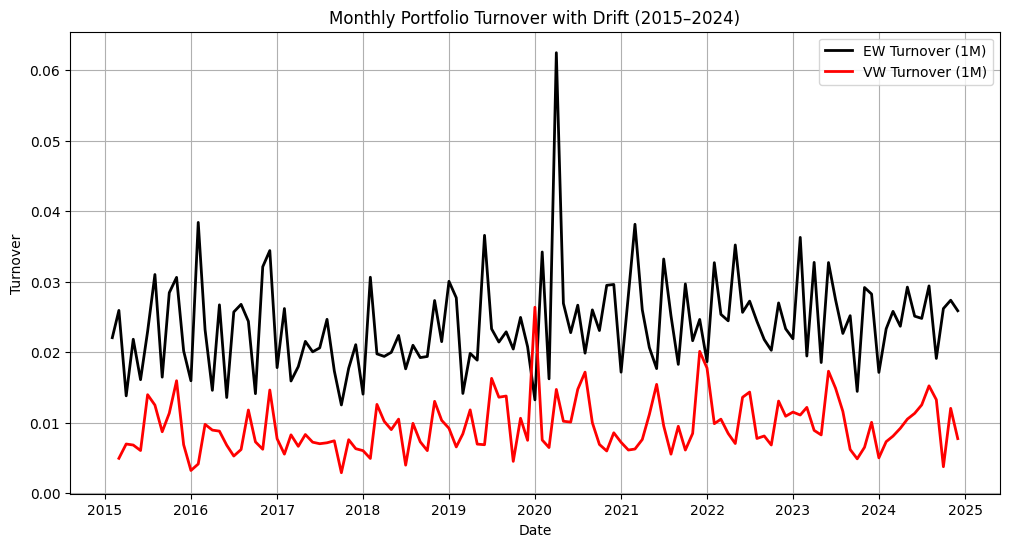

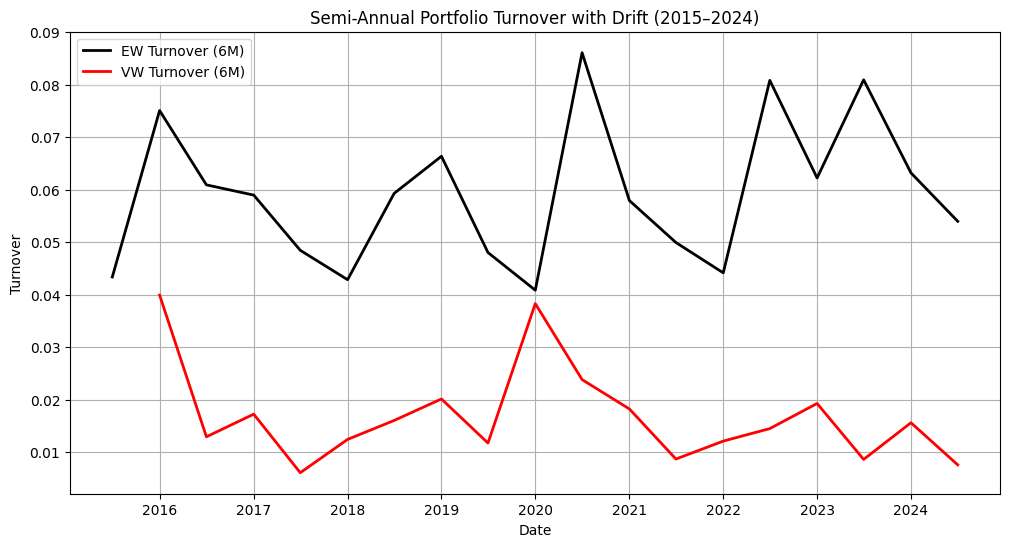

In [68]:
plt.figure(figsize=(12,6))
plt.plot(ew_turnover_1m.index, ew_turnover_1m, label="EW Turnover (1M)", color="black", linewidth=2)
plt.plot(vw_turnover_1m.index, vw_turnover_1m, label="VW Turnover (1M)", color="red", linewidth=2)

plt.title("Monthly Portfolio Turnover with Drift (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(ew_turnover_6m.index, ew_turnover_6m, label="EW Turnover (6M)", color="black", linewidth=2)
plt.plot(vw_turnover_6m.index, vw_turnover_6m, label="VW Turnover (6M)", color="red", linewidth=2)

plt.title("Semi-Annual Portfolio Turnover with Drift (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.legend()
plt.grid(True)
plt.show()

# Calculate daily return from each portfolio

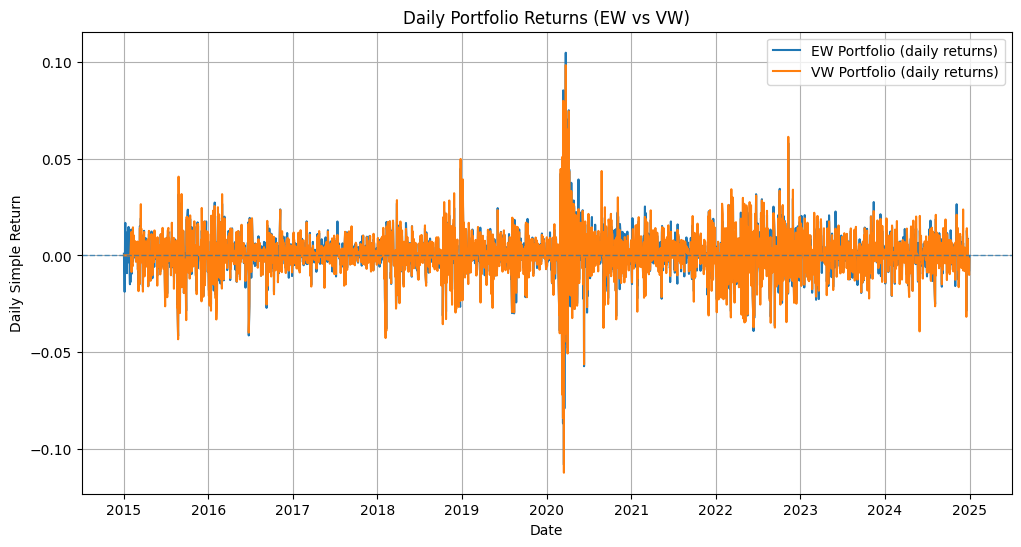

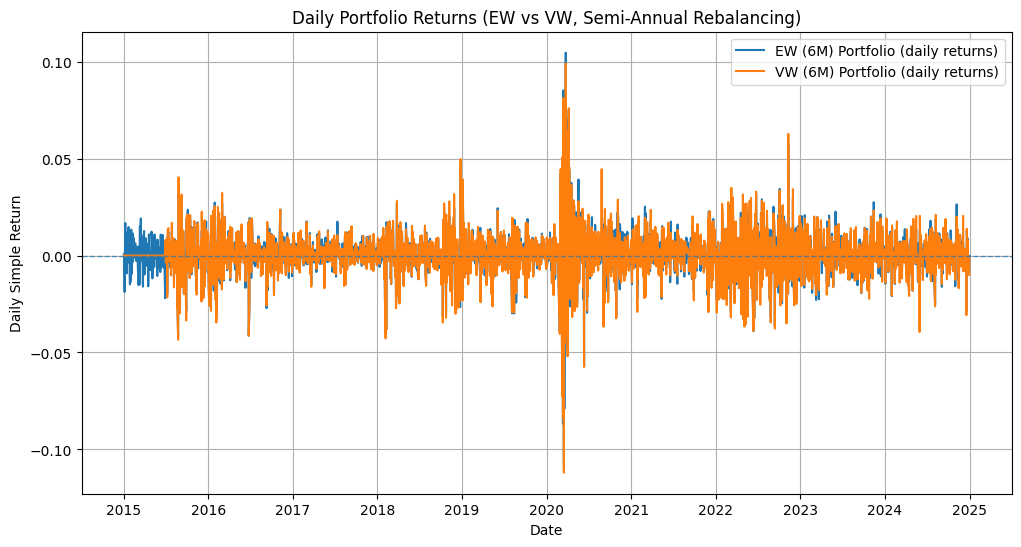

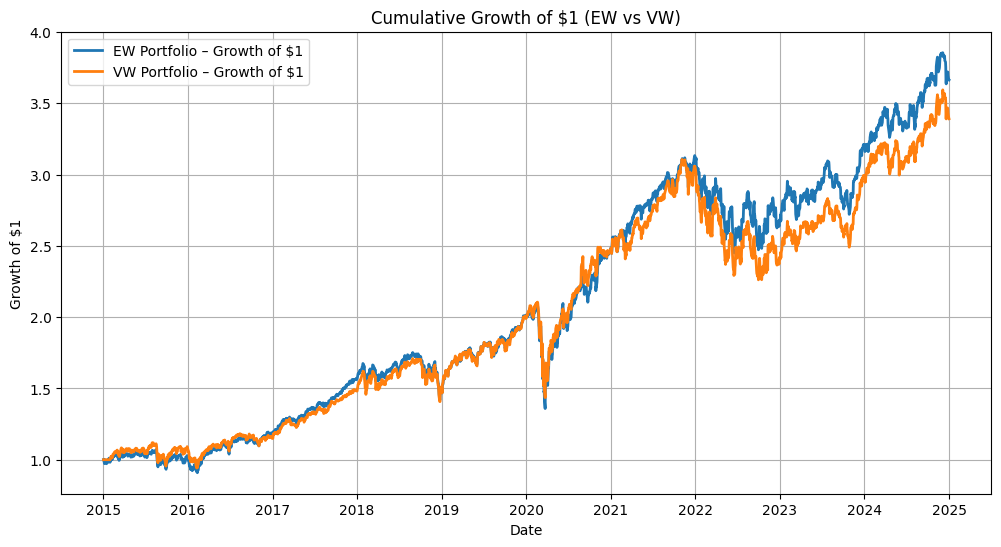

In [69]:
# 1) Stock-level daily SIMPLE returns from log returns
df_simple_returns = np.exp(df_returns[selected]) - 1
df_simple_returns = df_simple_returns.loc[df_simple_returns.index.intersection(df_returns.index)]

# 2) Ensure weights exist and are aligned to the simple returns index
idx = df_simple_returns.index

def ensure_daily_weights(weights_like, fallback_targets=None):
    """
    weights_like: daily path of weights already forward-filled (preferred)
    fallback_targets: rebalance-only targets; if provided, we forward-fill them to a daily path
    Returns: daily weights aligned to idx, restricted to 'selected' columns
    """
    if weights_like is not None:
        w = weights_like.copy()
        # Align to index and tickers
        w = w.reindex(idx).reindex(columns=selected)
        # If there are initial NaNs at top (before first rebalance), drop/forward-fill as needed
        w = w.ffill()
        return w
    elif fallback_targets is not None:
        w = fallback_targets.reindex(idx, method="ffill").reindex(columns=selected)
        return w.ffill()
    else:
        raise ValueError("No weights provided.")

# Use your existing monthly weight paths if available; otherwise fall back to monthly targets (if you named them)
ew_w_monthly = ensure_daily_weights(
    weights_like=locals().get("ew_monthly_weights", None),
    fallback_targets=locals().get("ew_monthly_targets", None)
)
vw_w_monthly = ensure_daily_weights(
    weights_like=locals().get("vw_monthly_weights", None),
    fallback_targets=locals().get("vw_monthly_targets", None)
)

# 3) Daily portfolio SIMPLE returns (monthly rebalanced)
ew_port_simple = (df_simple_returns * ew_w_monthly).sum(axis=1)
vw_port_simple = (df_simple_returns * vw_w_monthly).sum(axis=1)

# 4) Also provide LOG versions (often convenient for aggregation)
ew_port_log = np.log1p(ew_port_simple)
vw_port_log = np.log1p(vw_port_simple)

# 5) Store in df_returns for convenience
df_returns["EW_Portfolio"] = ew_port_simple
df_returns["VW_Portfolio"] = vw_port_simple
df_returns["EW_Portfolio_Log"] = ew_port_log
df_returns["VW_Portfolio_Log"] = vw_port_log

if "ew_6m_targets" in locals() and "vw_6m_targets" in locals():
    ew_w_6m = ew_6m_targets.reindex(idx, method="ffill").reindex(columns=selected).ffill()
    vw_w_6m = vw_6m_targets.reindex(idx, method="ffill").reindex(columns=selected).ffill()

    ew6_port_simple = (df_simple_returns * ew_w_6m).sum(axis=1)
    vw6_port_simple = (df_simple_returns * vw_w_6m).sum(axis=1)

    df_returns["EW6_Portfolio"] = ew6_port_simple
    df_returns["VW6_Portfolio"] = vw6_port_simple
    df_returns["EW6_Portfolio_Log"] = np.log1p(ew6_port_simple)
    df_returns["VW6_Portfolio_Log"] = np.log1p(vw6_port_simple)

# -------------------------------------------------------------------
# 6) Visualization: daily return series (continuous lines)
# -------------------------------------------------------------------

plt.figure(figsize=(12,6))
plt.plot(df_returns.index, df_returns["EW_Portfolio"], label="EW Portfolio (daily returns)", linewidth=1.5)
plt.plot(df_returns.index, df_returns["VW_Portfolio"], label="VW Portfolio (daily returns)", linewidth=1.5)
plt.axhline(0.0, linewidth=1, linestyle="--", alpha=0.7)
plt.title("Daily Portfolio Returns (EW vs VW)")
plt.xlabel("Date")
plt.ylabel("Daily Simple Return")
plt.legend()
plt.grid(True)
plt.show()

if "EW6_Portfolio" in df_returns.columns and "VW6_Portfolio" in df_returns.columns:
    plt.figure(figsize=(12,6))
    plt.plot(df_returns.index, df_returns["EW6_Portfolio"], label="EW (6M) Portfolio (daily returns)", linewidth=1.5)
    plt.plot(df_returns.index, df_returns["VW6_Portfolio"], label="VW (6M) Portfolio (daily returns)", linewidth=1.5)
    plt.axhline(0.0, linewidth=1, linestyle="--", alpha=0.7)
    plt.title("Daily Portfolio Returns (EW vs VW, Semi-Annual Rebalancing)")
    plt.xlabel("Date")
    plt.ylabel("Daily Simple Return")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------------------------------------------
# 7) Growth of $1 to sanity-check the path
#    Using LOG portfolio returns integrates exactly: exp(cumsum(log_returns))
#    Using SIMPLE portfolio returns: (1 + r).cumprod()
# -------------------------------------------------------------------

# From log returns (recommended for smoothness with your log series)
growth_ew = np.exp(df_returns["EW_Portfolio_Log"].cumsum())
growth_vw = np.exp(df_returns["VW_Portfolio_Log"].cumsum())

plt.figure(figsize=(12,6))
plt.plot(growth_ew.index, growth_ew, label="EW Portfolio – Growth of $1", linewidth=2)
plt.plot(growth_vw.index, growth_vw, label="VW Portfolio – Growth of $1", linewidth=2)
plt.title("Cumulative Growth of $1 (EW vs VW)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()


# Calculation part

In [79]:
import yfinance as yf
import numpy as np
import pandas as pd

# --- Get S&P500 benchmark ---
spx = yf.download("^GSPC", start="2015-01-01", end="2024-12-31", progress=False)
price_col = "Adj Close" if "Adj Close" in spx.columns else "Close"
sp500_log = np.log(spx[price_col] / spx[price_col].shift(1)).dropna()
# Ensure it's a Series, not DataFrame
if isinstance(sp500_log, pd.DataFrame):
    sp500_log = sp500_log.iloc[:, 0]  # Take first column as Series
sp500_log.name = "SP500_Log"

trading_days = 252

def portfolio_stats(port_log_returns, benchmark_log_returns=None, rf=0.0):
    port = port_log_returns.dropna()

    # Align benchmark to portfolio index using intersection
    if benchmark_log_returns is not None:
        common_idx = port.index.intersection(benchmark_log_returns.index)
        port = port.loc[common_idx]
        benchmark = benchmark_log_returns.loc[common_idx]
    else:
        benchmark = None

    # Annualized return - use .values[0] for scalar extraction
    mean_daily = port.mean().values[0] if hasattr(port.mean(), 'values') else port.mean()
    ann_return = np.exp(mean_daily * trading_days) - 1

    # Annualized volatility - use .values[0] for scalar extraction  
    vol_daily = port.std().values[0] if hasattr(port.std(), 'values') else port.std()
    ann_vol = vol_daily * np.sqrt(trading_days)

    # Sharpe ratio
    sharpe = (ann_return - rf) / ann_vol

    results = {
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe
    }

    # Information ratio
    if benchmark is not None:
        active = (port - benchmark).dropna()
        mean_active = active.mean() if not hasattr(active.mean(), 'values') else active.mean().values[0] if len(active.mean().values) == 1 else active.mean()
        std_active = active.std() if not hasattr(active.std(), 'values') else active.std().values[0] if len(active.std().values) == 1 else active.std()
        
        ann_active_return = float(mean_active) * trading_days
        ann_tracking_error = float(std_active) * np.sqrt(trading_days)
        info_ratio = ann_active_return / ann_tracking_error if ann_tracking_error != 0 else np.nan
        results["Information Ratio"] = info_ratio

    return results

# --- Compute stats ---
ew_stats = portfolio_stats(df_returns["EW_Portfolio_Log"], benchmark_log_returns=sp500_log)
vw_stats = portfolio_stats(df_returns["VW_Portfolio_Log"], benchmark_log_returns=sp500_log)

# --- Print results nicely ---
print("Equal-Weighted Portfolio Stats:")
for k, v in ew_stats.items():
    print(f"  {k}: {v:.4f}")

print("\nValue-Weighted Portfolio Stats:")
for k, v in vw_stats.items():
    print(f"  {k}: {v:.4f}")

Equal-Weighted Portfolio Stats:
  Annualized Return: 0.1390
  Annualized Volatility: 0.1820
  Sharpe Ratio: 0.7637
  Information Ratio: 0.4333

Value-Weighted Portfolio Stats:
  Annualized Return: 0.1304
  Annualized Volatility: 0.1886
  Sharpe Ratio: 0.6916
  Information Ratio: 0.2552


C:\Users\lucaf\AppData\Local\Temp\ipykernel_26944\512443766.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download("^GSPC", start="2015-01-01", end="2024-12-31", progress=False)



Portfolio Performance Summary (2015–2024):


,Annualized Return,Annualized Volatility,Sharpe Ratio,Information Ratio vs SPX
EW,13.90%,18.20%,0.76,0.43
VW,13.04%,18.86%,0.69,0.26
S&P 500,11.15%,17.89%,0.62,nan


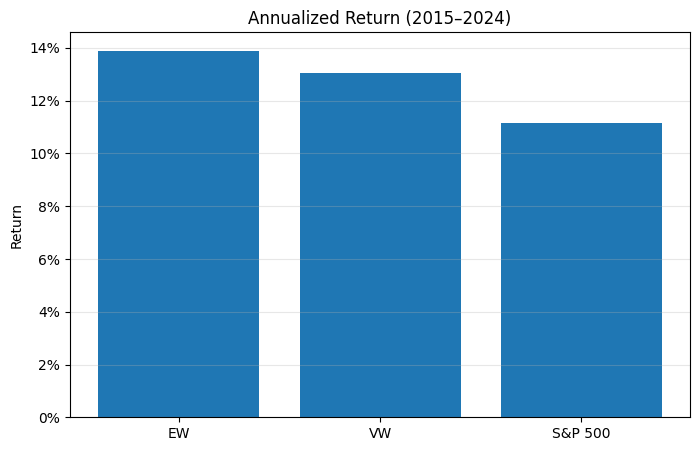

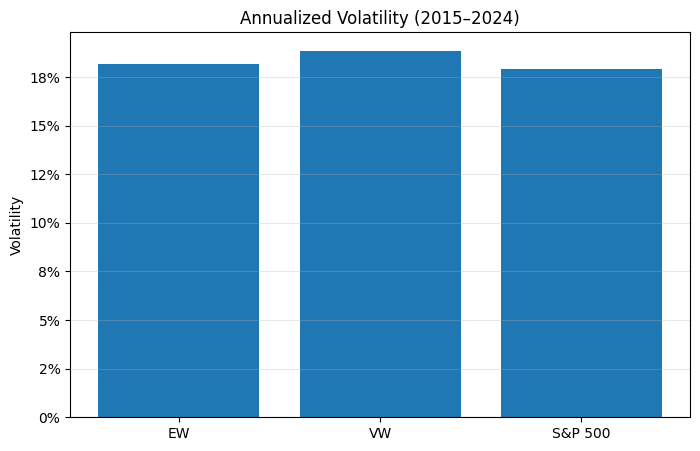

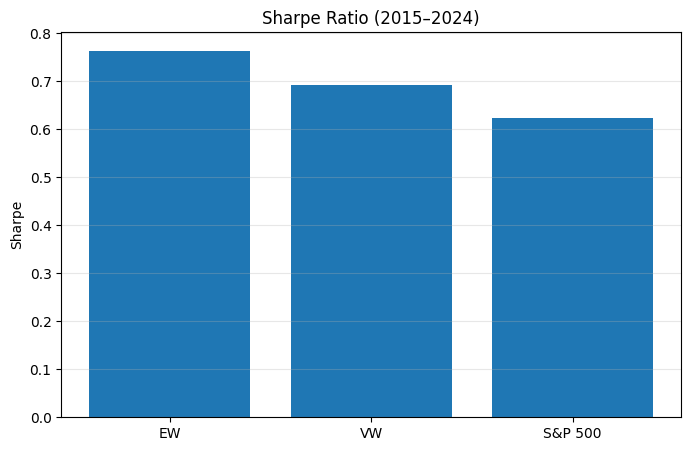

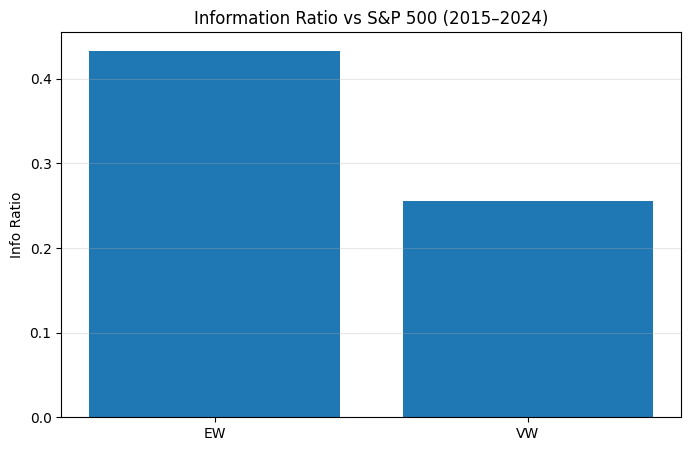

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- Compute SP500 summary stats (rf = 0) -----
trading_days = 252
spx_ann_ret = np.exp(sp500_log.mean() * trading_days) - 1
spx_ann_vol = sp500_log.std() * np.sqrt(trading_days)
spx_sharpe  = (spx_ann_ret - 0.0) / spx_ann_vol

# ----- Build a summary table -----
summary = pd.DataFrame({
    "Annualized Return": {
        "EW": ew_stats["Annualized Return"],
        "VW": vw_stats["Annualized Return"],
        "S&P 500": spx_ann_ret
    },
    "Annualized Volatility": {
        "EW": ew_stats["Annualized Volatility"],
        "VW": vw_stats["Annualized Volatility"],
        "S&P 500": spx_ann_vol
    },
    "Sharpe Ratio": {
        "EW": ew_stats["Sharpe Ratio"],
        "VW": vw_stats["Sharpe Ratio"],
        "S&P 500": spx_sharpe
    },
    # Info Ratio only makes sense vs. the benchmark; omit for SPX
    "Information Ratio vs SPX": {
        "EW": ew_stats.get("Information Ratio", np.nan),
        "VW": vw_stats.get("Information Ratio", np.nan),
        "S&P 500": np.nan
    }
})

# Nice printout
print("\nPortfolio Performance Summary (2015–2024):")
display(summary.style.format({
    "Annualized Return": "{:.2%}",
    "Annualized Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Information Ratio vs SPX": "{:.2f}"
}))

# ----- Plots (one metric per figure; clean & readable) -----

# 1) Annualized Return
plt.figure(figsize=(8,5))
plt.bar(summary.index, summary["Annualized Return"])
plt.title("Annualized Return (2015–2024)")
plt.ylabel("Return")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
plt.grid(axis="y", alpha=0.3)
plt.show()

# 2) Annualized Volatility
plt.figure(figsize=(8,5))
plt.bar(summary.index, summary["Annualized Volatility"])
plt.title("Annualized Volatility (2015–2024)")
plt.ylabel("Volatility")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
plt.grid(axis="y", alpha=0.3)
plt.show()

# 3) Sharpe Ratio
plt.figure(figsize=(8,5))
plt.bar(summary.index, summary["Sharpe Ratio"])
plt.title("Sharpe Ratio (2015–2024)")
plt.ylabel("Sharpe")
plt.grid(axis="y", alpha=0.3)
plt.show()

# 4) Information Ratio (only EW/VW)
plt.figure(figsize=(8,5))
ir_series = summary.loc[["EW", "VW"], "Information Ratio vs SPX"].astype(float)
plt.bar(ir_series.index, ir_series.values)
plt.title("Information Ratio vs S&P 500 (2015–2024)")
plt.ylabel("Info Ratio")
plt.grid(axis="y", alpha=0.3)
plt.show()


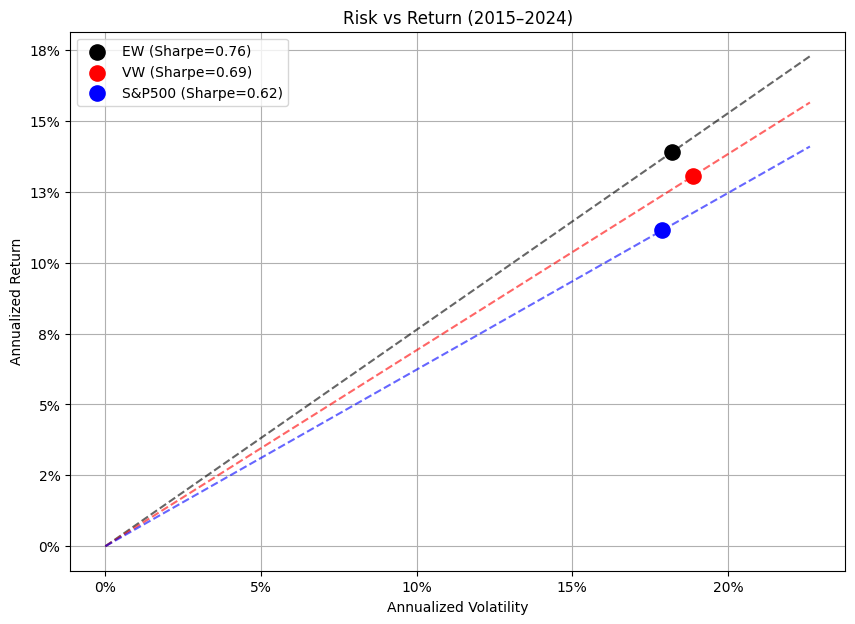

In [81]:
import matplotlib.pyplot as plt

# --- Collect stats ---
ew_ret, ew_vol, ew_sharpe = ew_stats["Annualized Return"], ew_stats["Annualized Volatility"], ew_stats["Sharpe Ratio"]
vw_ret, vw_vol, vw_sharpe = vw_stats["Annualized Return"], vw_stats["Annualized Volatility"], vw_stats["Sharpe Ratio"]

# Benchmark stats (from earlier calc)
spx_ann_ret, spx_ann_vol, spx_sharpe = (
    np.exp(sp500_log.mean() * trading_days) - 1,
    sp500_log.std() * np.sqrt(trading_days),
    (np.exp(sp500_log.mean() * trading_days) - 1) / (sp500_log.std() * np.sqrt(trading_days))
)

# --- Scatter plot ---
plt.figure(figsize=(10,7))

plt.scatter(ew_vol, ew_ret, color="black", s=120, marker="o", label=f"EW (Sharpe={ew_sharpe:.2f})")
plt.scatter(vw_vol, vw_ret, color="red", s=120, marker="o", label=f"VW (Sharpe={vw_sharpe:.2f})")
plt.scatter(spx_ann_vol, spx_ann_ret, color="blue", s=120, marker="o", label=f"S&P500 (Sharpe={spx_sharpe:.2f})")

# Draw Sharpe lines (Capital Market Line style)
max_vol = max(ew_vol, vw_vol, spx_ann_vol) * 1.2
for ret, vol, sharpe, color in [
    (ew_ret, ew_vol, ew_sharpe, "black"),
    (vw_ret, vw_vol, vw_sharpe, "red"),
    (spx_ann_ret, spx_ann_vol, spx_sharpe, "blue")
]:
    x_vals = np.linspace(0, max_vol, 100)
    y_vals = sharpe * x_vals
    plt.plot(x_vals, y_vals, linestyle="--", color=color, alpha=0.6)

# Labels and style
plt.title("Risk vs Return (2015–2024)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)

# Format as percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.show()


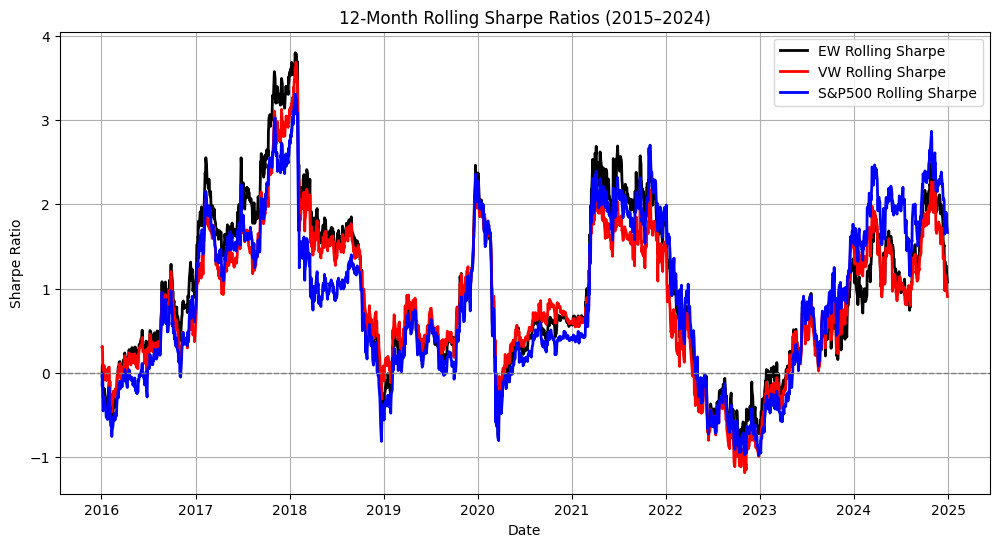

In [82]:
import matplotlib.pyplot as plt

# --- Prepare series ---
ew_log = df_returns["EW_Portfolio_Log"].dropna()
vw_log = df_returns["VW_Portfolio_Log"].dropna()
spx_log = sp500_log.dropna()

# Align all to common dates
common_idx = ew_log.index.intersection(vw_log.index).intersection(spx_log.index)
ew_log, vw_log, spx_log = ew_log.loc[common_idx], vw_log.loc[common_idx], spx_log.loc[common_idx]

# --- Rolling Sharpe function ---
def rolling_sharpe(series, window=252):
    mean = series.rolling(window).mean() * trading_days
    vol = series.rolling(window).std() * np.sqrt(trading_days)
    sharpe = mean / vol
    return sharpe

# --- Compute 12M rolling Sharpe ---
ew_roll_sharpe = rolling_sharpe(ew_log, 252)
vw_roll_sharpe = rolling_sharpe(vw_log, 252)
spx_roll_sharpe = rolling_sharpe(spx_log, 252)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(ew_roll_sharpe.index, ew_roll_sharpe, label="EW Rolling Sharpe", color="black", linewidth=2)
plt.plot(vw_roll_sharpe.index, vw_roll_sharpe, label="VW Rolling Sharpe", color="red", linewidth=2)
plt.plot(spx_roll_sharpe.index, spx_roll_sharpe, label="S&P500 Rolling Sharpe", color="blue", linewidth=2)

plt.title("12-Month Rolling Sharpe Ratios (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.grid(True)
plt.show()


# Cumulativa Returns for both Portfolios, S&P500 and risk-free

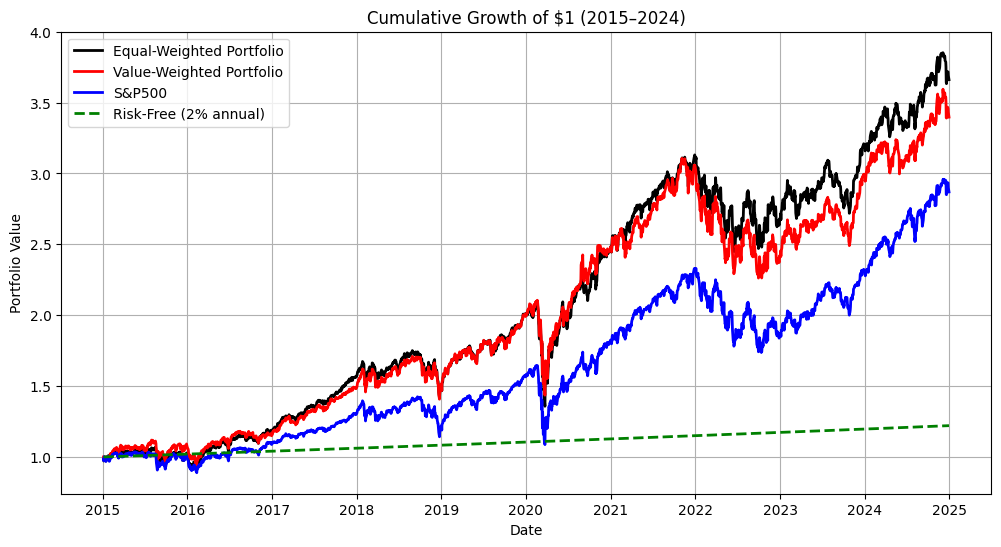

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare log returns (already in df_returns) ---
ew_log = df_returns["EW_Portfolio_Log"].dropna()
vw_log = df_returns["VW_Portfolio_Log"].dropna()
spx_log = sp500_log.dropna()

# Align to common index
common_idx = ew_log.index.intersection(vw_log.index).intersection(spx_log.index)
ew_log, vw_log, spx_log = ew_log.loc[common_idx], vw_log.loc[common_idx], spx_log.loc[common_idx]

# --- Compute cumulative returns (Growth of $1) ---
ew_cum = np.exp(ew_log.cumsum())
vw_cum = np.exp(vw_log.cumsum())
spx_cum = np.exp(spx_log.cumsum())

# Risk-free: assume 2% annualized constant rate
rf_rate = 0.02
rf_daily = rf_rate / 252
rf_cum = np.exp(rf_daily * np.arange(len(common_idx)))
rf_cum = pd.Series(rf_cum, index=common_idx, name="Risk-Free")

# --- Plot cumulative growth ---
plt.figure(figsize=(12,6))
plt.plot(ew_cum.index, ew_cum, label="Equal-Weighted Portfolio", linewidth=2, color="black")
plt.plot(vw_cum.index, vw_cum, label="Value-Weighted Portfolio", linewidth=2, color="red")
plt.plot(spx_cum.index, spx_cum, label="S&P500", linewidth=2, color="blue")
plt.plot(rf_cum.index, rf_cum, label="Risk-Free (2% annual)", linewidth=2, color="green", linestyle="--")

plt.title("Cumulative Growth of $1 (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


In [78]:
# Debug the benchmark alignment issue
print("Portfolio index range:", df_returns["EW_Portfolio_Log"].index.min(), "to", df_returns["EW_Portfolio_Log"].index.max())
print("SP500 index range:", sp500_log.index.min(), "to", sp500_log.index.max())
print("Common dates:", len(df_returns["EW_Portfolio_Log"].index.intersection(sp500_log.index)))
print("Portfolio dates:", len(df_returns["EW_Portfolio_Log"].index))
print("SP500 dates:", len(sp500_log.index))

# Check if benchmark is actually a Series
print("SP500 log type:", type(sp500_log))
print("SP500 log shape:", sp500_log.shape)
print("SP500 log first few values:")
print(sp500_log.head())

Portfolio index range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
SP500 index range: 2015-01-05 00:00:00 to 2024-12-30 00:00:00
Common dates: 2514
Portfolio dates: 2608
SP500 dates: 2514
SP500 log type: <class 'pandas.core.frame.DataFrame'>
SP500 log shape: (2514, 1)
SP500 log first few values:
Ticker         ^GSPC
Date                
2015-01-05 -0.018447
2015-01-06 -0.008933
2015-01-07  0.011563
2015-01-08  0.017730
2015-01-09 -0.008439


# Part B

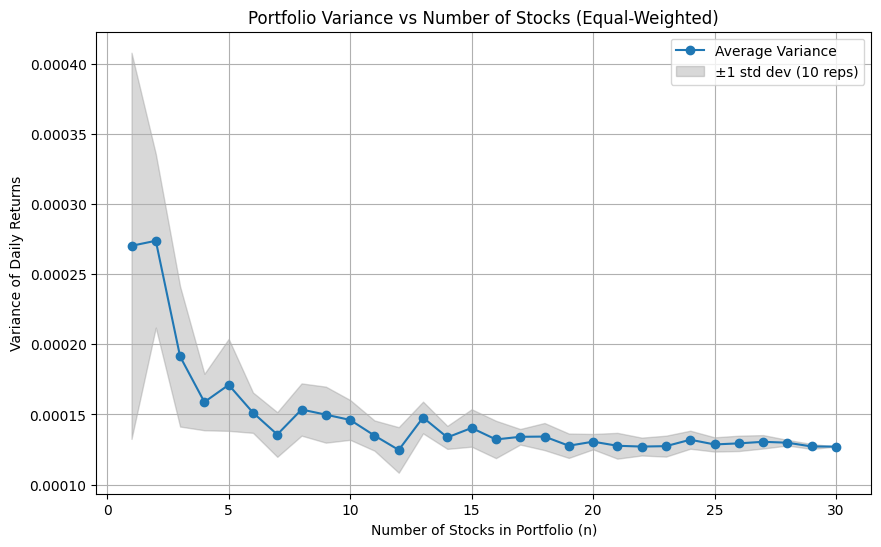

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Data: daily log returns for the 30 selected stocks ---
stock_returns = df_returns[selected].dropna()

# --- Parameters ---
reps = 10
max_n = len(selected)
results = []

# --- Experiment ---
np.random.seed(42)  # reproducibility

for n in range(1, max_n+1):
    variances = []
    for _ in range(reps):
        # (a) choose n stocks
        chosen = np.random.choice(selected, size=n, replace=False)
        
        # (b) equal-weighted portfolio return
        port_rets = stock_returns[chosen].mean(axis=1)
        
        # (c) compute variance of daily return
        var = port_rets.var()
        variances.append(var)
    
    # store average variance for this n
    results.append({
        "n": n,
        "avg_variance": np.mean(variances),
        "std_variance": np.std(variances)  # spread across runs
    })

# --- Convert to DataFrame ---
df_var = pd.DataFrame(results)

# --- Plot: Portfolio variance vs n ---
plt.figure(figsize=(10,6))
plt.plot(df_var["n"], df_var["avg_variance"], marker="o", label="Average Variance")
plt.fill_between(df_var["n"], 
                 df_var["avg_variance"] - df_var["std_variance"],
                 df_var["avg_variance"] + df_var["std_variance"],
                 color="gray", alpha=0.3, label="±1 std dev (10 reps)")
plt.title("Portfolio Variance vs Number of Stocks (Equal-Weighted)")
plt.xlabel("Number of Stocks in Portfolio (n)")
plt.ylabel("Variance of Daily Returns")
plt.legend()
plt.grid(True)
plt.show()
